In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SERVS and SWIRE) I will split the XID+ run into two different runs. Here we use the SERVS depth.

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../data/ELAIS_N1/MOCs/holes_ELAIS-N1_irac1_O16_MOC.fits')
SERVS_MOC=pymoc.MOC()
SERVS_MOC.read('../data/ELAIS_N1/MOCs/DF-SERVS_ELAIS-N1_MOC.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../data/ELAIS_N1/MOCs/DF-SWIRE_ELAIS-N1_MOC.fits')
Final=Sel_func.intersection(SWIRE_MOC)
Final=Final-SERVS_MOC


## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../data/ELAIS_N1/MIPS/dmu26_XID+MIPS_ELAIS-N1_SWIRE_cat_20170725.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,
str100,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool
HELP_J160000.316+542000.690,240.001318675,54.3335249815,1928.47,1943.4,1913.42,-0.000955198,4.74435e-06,nan,1196.0,1.0,True,True
HELP_J161145.788+525236.929,242.94078253,52.8769246635,244.531,531.299,80.7009,0.011866,5.16518e-06,1.00054,1760.0,0.0,False,False
HELP_J161138.168+525244.570,242.909032282,52.8790472905,239.355,531.635,65.6535,0.011866,5.16518e-06,1.00149,2000.0,0.0,False,False
HELP_J161143.750+525251.314,242.93229323,52.8809206325,242.255,516.11,71.3392,0.011866,5.16518e-06,1.00016,2000.0,0.0,False,False
HELP_J161131.547+525241.333,242.881447116,52.8781479465,262.442,560.661,81.3861,-0.00204203,4.91504e-06,1.00381,2000.0,0.0,False,False
HELP_J161128.756+525312.827,242.869815896,52.8868964635,256.02,554.574,68.8019,-0.00204203,4.91504e-06,1.00221,1068.0,0.0,False,False
HELP_J161132.773+525325.277,242.886553205,52.8903547935,68.2279,171.721,16.9382,0.377187,4.94219e-06,nan,2000.0,0.0,False,False
HELP_J161138.691+525423.576,242.911211156,52.9065487865,67.2236,176.488,18.5074,0.377187,4.94219e-06,nan,2000.0,0.0,False,False


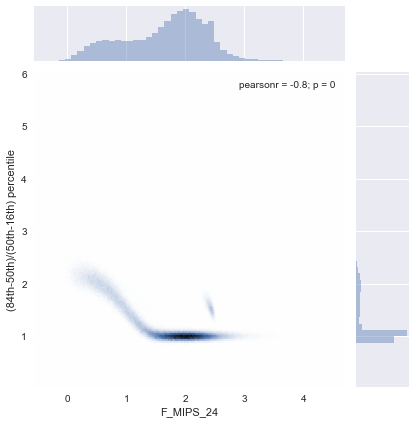

In [6]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24']),y=skew, kind='hex')


The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [7]:
good=XID_MIPS['F_MIPS_24']>20

In [8]:
good.sum()

149329

## Read in Maps

In [11]:

pswfits='../data/ELAIS_N1/SPIRE/ELAIS-N1-NEST_image_250_SMAP_v6.0.fits'#SPIRE 250 map
pmwfits='../data/ELAIS_N1/SPIRE/ELAIS-N1-NEST_image_350_SMAP_v6.0.fits'#SPIRE 350 map
plwfits='../data/ELAIS_N1/SPIRE/ELAIS-N1-NEST_image_500_SMAP_v6.0.fits'#SPIRE 500 map

#output folder
output_folder='./'

In [12]:
from astropy.io import fits
from astropy import wcs

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[2].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[2].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [13]:
## Set XID+ prior class

In [14]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N1-SERVS.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Final)
prior350.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N1-SERVS.fits',ID=XID_MIPS['help_id'][good])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Final)
prior500.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N1-SERVS.fits',ID=XID_MIPS['help_id'][good])
prior500.prior_bkg(-5.0,5)

In [15]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [16]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
outfile=output_folder+'Master_prior_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 614 tiles required for input catalogue and 20 large tiles


SystemExit: 